/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:245: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


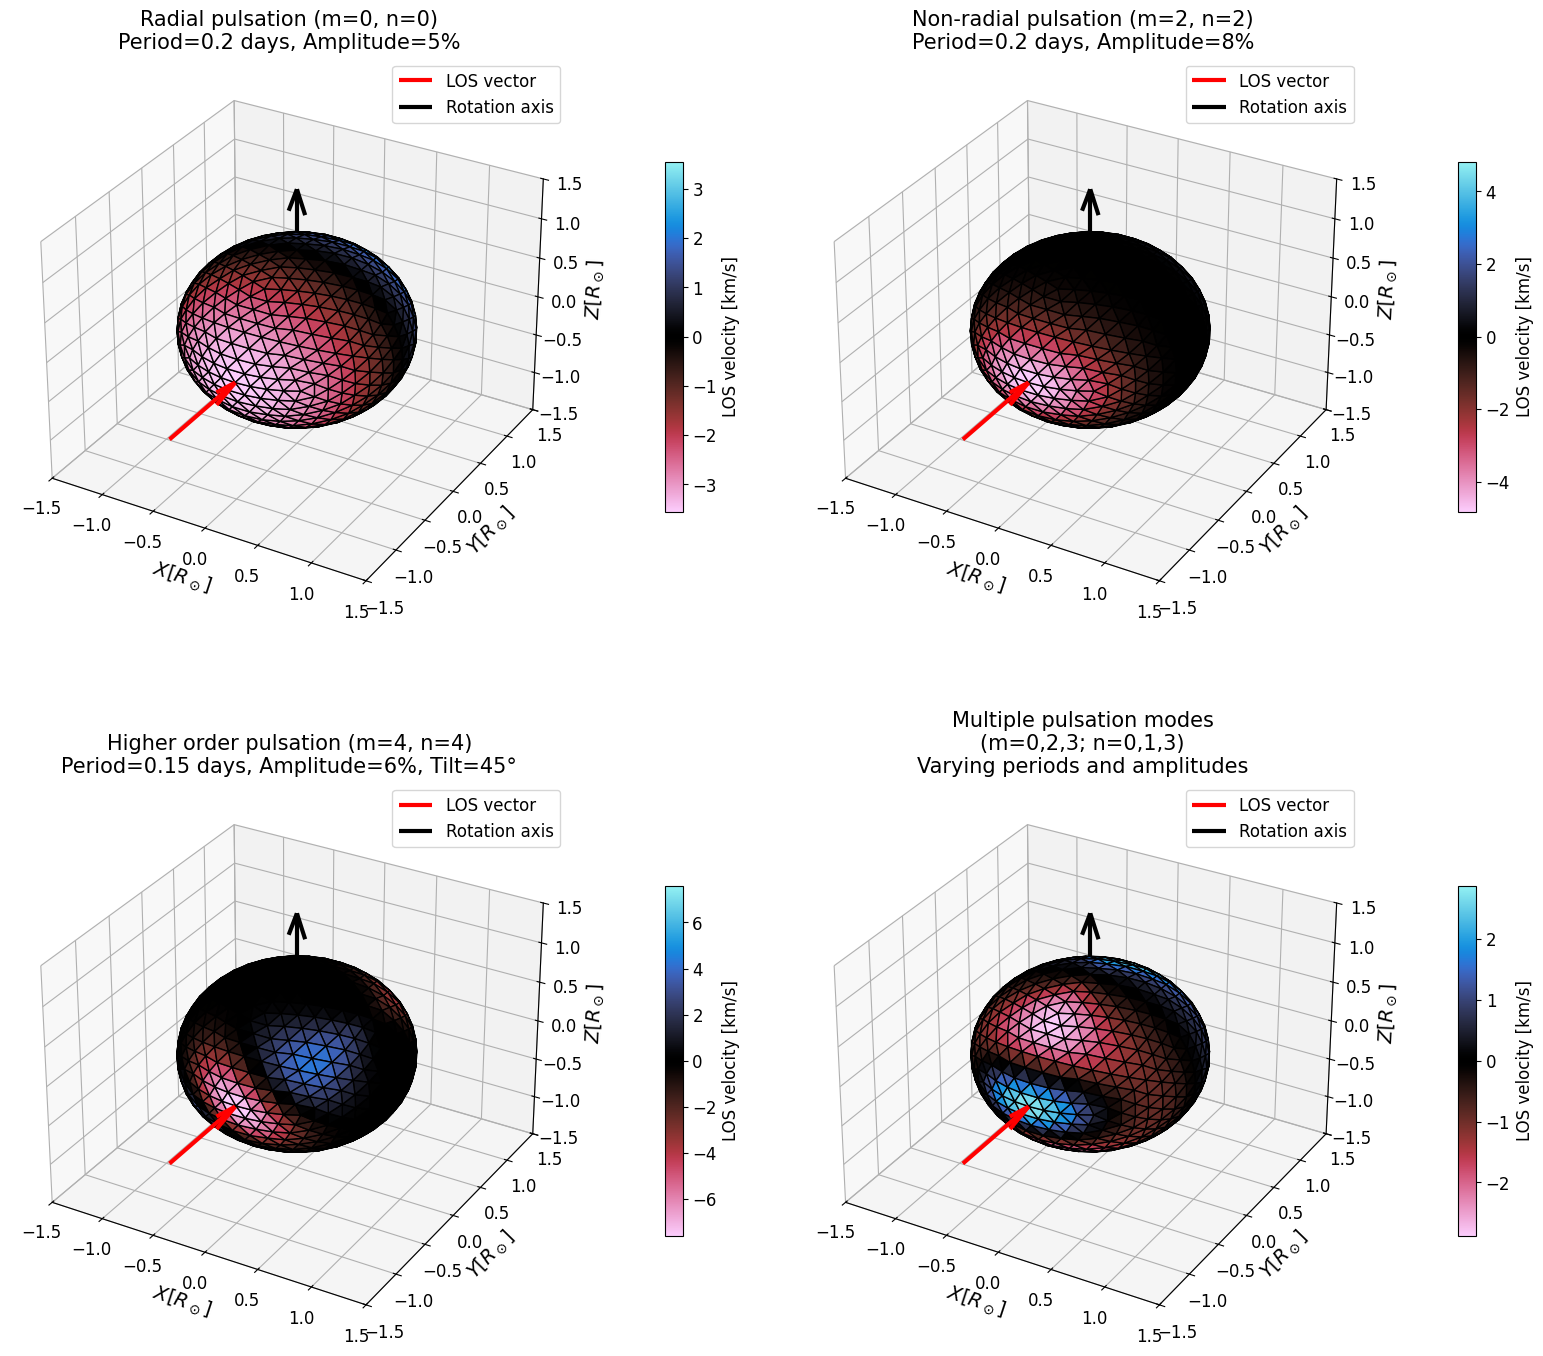

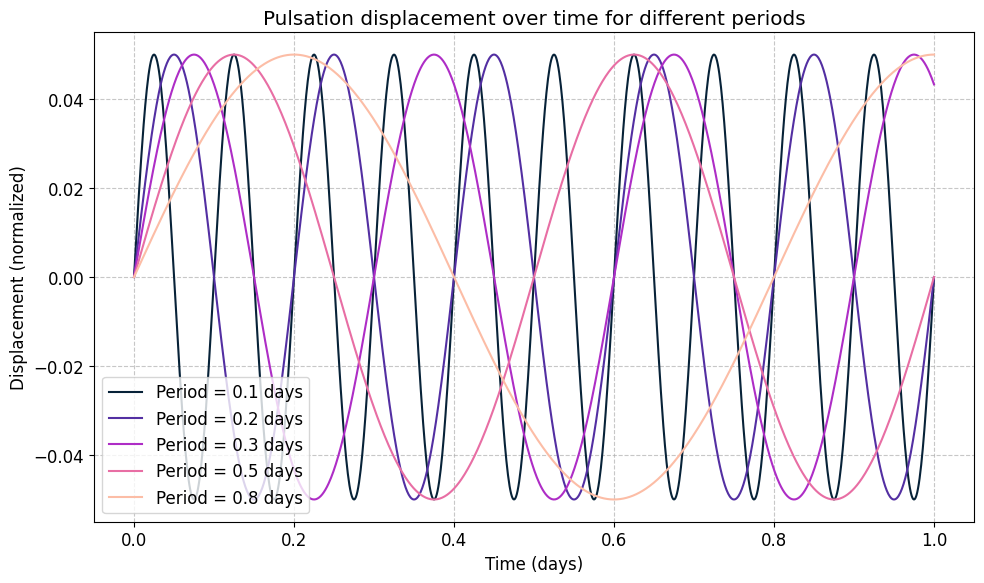

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import cmasher as cmr
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_pulsation, add_pulsations, evaluate_pulsations, reset_pulsations
from spice.plots import plot_3D
from transformer_payne import Blackbody

# Set up the notebook for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Create a blackbody parameterization for temperature
bb = Blackbody()

EV_TIME = 0.05

# Create base model with temperature of 5700K
base_temp = 5700
m = IcosphereModel.construct(1000, 1., 1., bb.to_parameters(dict(teff=base_temp)), bb.parameter_names)

# Create a 2x2 grid of pulsation configurations
fig = plt.figure(figsize=(16, 16))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
axes = [
    [fig.add_subplot(2, 2, 1, projection='3d'), fig.add_subplot(2, 2, 2, projection='3d')],
    [fig.add_subplot(2, 2, 3, projection='3d'), fig.add_subplot(2, 2, 4, projection='3d')]
]

# Configuration 1: Simple radial pulsation (m=0, n=0)
m_pulsation1 = add_pulsation(
    m,
    m_order=jnp.array([0]),
    n_degree=jnp.array([0]),
    period=jnp.array([0.2]),  # 0.1 day period
    fourier_series_parameters=jnp.array([[0.05, 0.0]])  # Simple sine wave with 5% amplitude
)
m_pulsation1 = evaluate_pulsations(m_pulsation1, EV_TIME)
ax1 = plot_3D(m_pulsation1, property='los_velocities', axes=(fig, axes[0][0]), property_label="LOS velocity [km/s]")
axes[0][0].set_title(f"Radial pulsation (m=0, n=0)\nPeriod=0.2 days, Amplitude=5%", fontsize=15)

# Configuration 2: Non-radial pulsation (m=2, n=2)
m_pulsation2 = add_pulsations(
    m,
    m_orders=jnp.array([2]),
    n_degrees=jnp.array([2]),
    periods=jnp.array([0.2]),  # 0.2 day period
    fourier_series_parameters=jnp.array([[0.05, 0.0]])  # Simple sine wave with 8% amplitude
)
m_pulsation2 = evaluate_pulsations(m_pulsation2, EV_TIME)
ax2 = plot_3D(m_pulsation2, property='los_velocities', axes=(fig, axes[0][1]), property_label="LOS velocity [km/s]")
axes[0][1].set_title(f"Non-radial pulsation (m=2, n=2)\nPeriod=0.2 days, Amplitude=8%", fontsize=15)

# Configuration 3: Higher order non-radial pulsation (m=4, n=4)
m_pulsation3 = add_pulsations(
    m,
    m_orders=jnp.array([4]),
    n_degrees=jnp.array([4]),
    periods=jnp.array([0.15]),  # 0.15 day period
    fourier_series_parameters=jnp.array([[0.06, 0.0]]),  # Simple sine wave with 6% amplitude
    pulsation_axes=jnp.array([[0.0, 1.0, 0.0]]),
    pulsation_angles=jnp.array([45.0])  # 45 degree tilt
)
m_pulsation3 = evaluate_pulsations(m_pulsation3, EV_TIME)
ax3 = plot_3D(m_pulsation3, property='los_velocities', axes=(fig, axes[1][0]), property_label="LOS velocity [km/s]")
axes[1][0].set_title(f"Higher order pulsation (m=4, n=4)\nPeriod=0.15 days, Amplitude=6%, Tilt=45°", fontsize=15)

# Configuration 4: Multiple pulsation modes
m_pulsation4 = add_pulsations(
    m,
    m_orders=jnp.array([0, 2, 3]),
    n_degrees=jnp.array([0, 1, 3]),
    periods=jnp.array([0.15, 0.1, 0.2]),  # Different periods
    fourier_series_parameters=jnp.array([
        [0.03, 0.0],  # First mode
        [0.04, 0.0],  # Second mode
        [0.05, 0.0]  # Third mode
    ])
)
m_pulsation4 = evaluate_pulsations(m_pulsation4, EV_TIME)
ax4 = plot_3D(m_pulsation4, property='los_velocities', axes=(fig, axes[1][1]), property_label="LOS velocity [km/s]")
axes[1][1].set_title(f"Multiple pulsation modes\n(m=0,2,3; n=0,1,3)\nVarying periods and amplitudes", fontsize=15)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)

# Create a figure to demonstrate how pulsation amplitude varies with different periods
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Define a range of time points
time_points = np.linspace(0, 1, 1000)  # 1 day

# Define different periods to plot
periods = [0.1, 0.2, 0.3, 0.5, 0.8]
colors = cmr.bubblegum(np.linspace(0, 1, len(periods)))

for i, period in enumerate(periods):
    # Simple sine wave with amplitude 0.05
    amplitude = 0.05
    displacement = amplitude * np.sin(2 * np.pi * time_points / period)
    ax2.plot(time_points, displacement, color=colors[i], label=f"Period = {period} days")

ax2.set_xlabel("Time (days)")
ax2.set_ylabel("Displacement (normalized)")
ax2.set_title("Pulsation displacement over time for different periods")
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend()
plt.tight_layout()
